# Chebyshev spectral methods for advection using Chebfun

Solve the advection equation $u_t=u_x$ on $-1\leq x \leq 1$ with $u(1,t) = g(t)$ using the Chebyshev Spectral method to discretize in space and forward Euler in time.  

Running this notebook requires Jupyter notebooks with the [matlab_kernel](https://pypi.python.org/pypi/matlab_kernel) installed, Matlab, and the Matlab package [chebfun](http://www.chebfun.org/).

Developed by Randy LeVeque for a course on Approximation Theory and Spectral Methods at the University of Washington. See <http://faculty.washington.edu/rjl/classes/am570a2015/codes.html> for more IPython Notebook examples.

In [1]:
path(path,'/Users/rjl/git/chebfun')   # modify this for your local system

### Define the discrete differentiation operator with a boundary condition

Now consider the differential operator $\partial_x$ on $[-1,1]$ with the boundary condition $u(1) = 0$. 

In [6]:
N = 50;
Dop = chebop(@(u) diff(u));
D = matrix(Dop,N, 'oldschool');
D = D(1:N-1, 1:N-1); % part of matrix to use for homogeneous BC

Let $U =[U_0,~U_1,~\ldots,~U_{N-1}]^T$ be the vector of values at $x_j = -\cos(\pi j/N)$ for $j=0,~1,~\ldots,~N-1$, i.e. not including the right boundary where we the value will be determined by the boundary condition.  

Note that the matrix $D$ defined above maps values $U$ to approximations to $u'(x_j)$ at these same set of points, assuming that $U_N=0$.  

To solve the advection equation with $g(t) \equiv 0$, we can use this operator to obtain the semi-discrete ODE $U'(t) = DU(t)$. 

## Initial conditions and true solution:

Use Gaussian initial conditions $u(x,0) = \exp(-50 (x-0.5)^2)$.  Note that in general the solution is $u(x,t) = u(x+t,0)$, so define the true solution:

In [7]:
utrue_func = @(x,t) exp(-50*(x+t-0.5).^2);

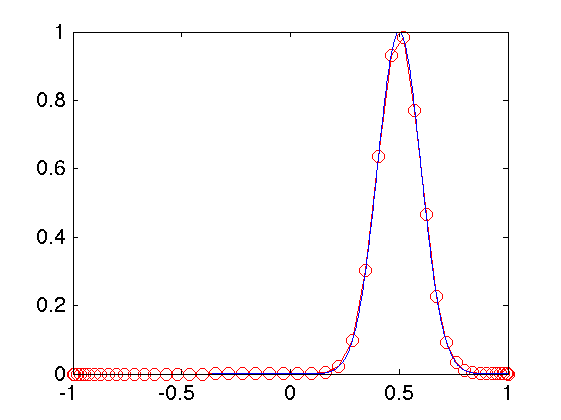

In [8]:
x_all = chebpts(N);     % note that this returns points ordered from -1 to 1
x = x_all(1:N-1);    % interior points, other than right boundary

u = utrue_func(x,0.);
u_all = [u; 0];   % append boundary value for plotting
plot(x_all,u_all,'r-o');

hold on
xfine = linspace(-1,1,1000);
ufine = utrue_func(xfine, 0.);
plot(xfine,ufine,'b')

## Time-stepping loop:

This is a simple example using Forward Euler time-stepping.


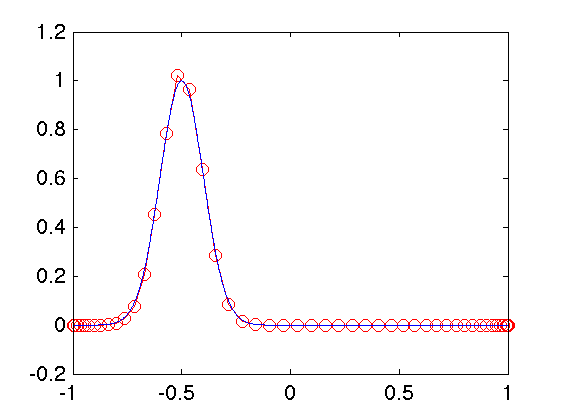

In [9]:
u = utrue_func(x,0.);

tfinal = 1.;
nmax = 0.5*N^2;
dt = tfinal/nmax;

for n=1:nmax
    u = u + dt*D*u;
    end

u_all = [u; 0];   % append boundary value for plotting
plot(x_all,u_all,'r-o');

hold on
xfine = linspace(-1,1,1000);
ufine = utrue_func(xfine, tfinal);
plot(xfine,ufine,'b')

Compute the maximum error at the gridpoints. 

In [10]:
utrue = utrue_func(x,tfinal);
norm(u-utrue,inf)

ans =
   0.040205874468365

Alternatively we can interpolate with a polynomial and compute the max-norm of the error in this function:

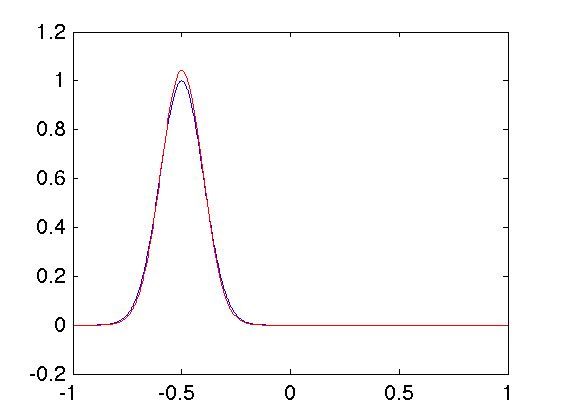

max_error =
   0.042563102066736

In [11]:
pn = chebfun(u_all);
phat = chebfun(@(x) utrue_func(x,tfinal));
max_error = norm(pn-phat,inf)
plot(phat,'b')
hold on 
plot(pn,'r')

## Convergence

Try changing N or nmax in the cells above and re-executing everything to see the effect of changing the resolution or time step.  You should find that the error goes to zero like ${\cal O}(1/N^2)$ as $N \rightarrow \infty$.  

Note that the spatial approximation to the deriviative should be (nearly) spectrally accurate for this (nearly) analytic initial data. (Note that $u(x,t)$ is actually not analytic because it should be identically 0 for $x+t \geq 1$ due to the boundary condition imposed so it has a very small discontinuity at this point, but this is around $10^{-8}$ for the Gaussian used here.)

The reason the PDE solution is only  ${\cal O}(1/N^2)$ accurate is that we are using the first-order accurate forward Euler method for the time stepping.  It is first order accurate in $\Delta t$, which has been set to $0.5 / N^2$ above.  This has been chosen for stability reasons.  One could get a more accurate solution by using a smaller $\Delta t$, or preferably by using a higher-order ODE method. 

 


## Stability

Recall that the upwind finite difference method is stable for $\Delta t \leq \Delta x$, so on a uniform grid with $N$ points in $[-1,1]$ this would allow $\Delta t \leq 2/N$.  But the Chebyshev grid spacing is smaller near the boundaries with $x_1 - x_0 = {\cal O}(1/N^2)$ and so the CFL condition would require that $\Delta t = {\cal O}(1/N^2)$ for an upwind finite difference method on this grid. 

The Chebyshev method has a much wider stencil than upwind -- it includes every point on the grid, and so the CFL condition doesn't given any guidance as to the stability restriction for the spectral method.  

But examining the spectra and pseudospectra of the $D$ matrix used for the spectral method shows that the maximum eigenvalue grows like $\max |\lambda| = {\cal O}(1/N^2)$.

Below we plot the eigenvalues of $\Delta t D$ along with the stability region for forward Euler and zoom in near the origin.  If the time step is small enough, the points should lie inside the circle.

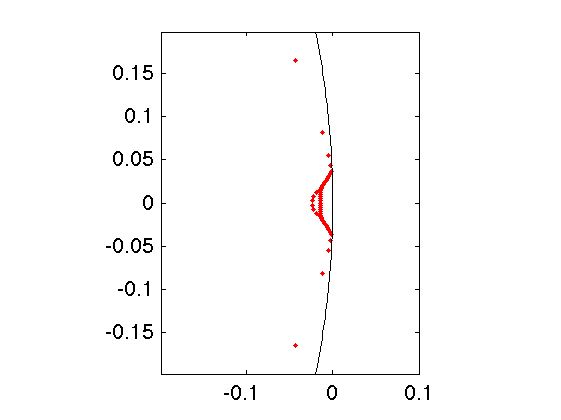

In [12]:
[V,Lam] = eig(D);
Lam = diag(Lam);
Lmax = max(real(Lam));
plot(real(Lam*dt), imag(Lam*dt),'r.')
eitheta = exp(1i*linspace(0,2*pi,1000));
hold on
plot(eitheta-1,'k')
axis 'equal'
xylim = dt*Lmax + 0.2;
axis([-xylim,0.1,-xylim,xylim])

### Pseudospectra

Since the matrix D is highly non-normal, we should also check that the $\lambda \Delta t$ lies in the stability region for $\lambda$ in the pseudospectrum of $D$ for small $\epsilon$...

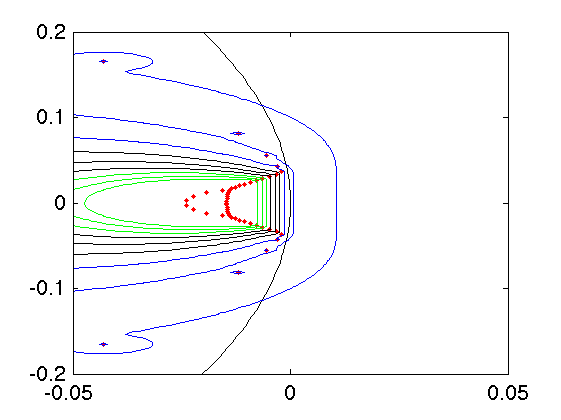

In [13]:
x1 = linspace(-.05,.05,100);
y1 = linspace(-.2,.2,200);
[xx,yy] = meshgrid(x1,y1);
zz = xx + 1i*yy;
I = eye(size(D,1));
sigmin = zeros(size(zz));
for j=1:length(x1)
    for i=1:length(y1)
        sigmin(i,j) = min(svd(zz(i,j)*I - dt*D));
        end
    end

plot(real(Lam*dt), imag(Lam*dt),'r.')
hold on
plot(eitheta-1,'k')
%axis 'equal'

axis([-.05,.05,-.2,.2])
contour(xx,yy,sigmin,[1e-2,1e-3,1e-4],'b')
contour(xx,yy,sigmin,[1e-5,1e-6,1e-7],'k')
contour(xx,yy,sigmin,[1e-8,1e-9,1e-10],'g')

Note that the pseudospectra for $\epsilon = 10^{-2}, 10^{-3}$ extend outside the region of absolute stability, but the important thing is that as $\epsilon \rightarrow 0$ the pseudospectra are within $O(\epsilon)$ of the region, and indeed they are inside for sufficiently small $\epsilon$.  

See the notebook [Dx_Pseudospectra.ipynb](Dx_Pseudospectra.ipynb) for more the pseudospectra of this operator.

## Nonhomogenous boundary conditions

Now consider the problem $u_t = u_x$ on $[-1,1]$ with $u(1,t) = g(t)$, some nonzero function.
Then the vector of unknowns is still the same $U$ as above, but to compute the approximation to $u'(x_j)$ at each point we need to include a contribution from the value $U_N$. 

The product $DU$ is missing this term, but it can be restored using the vector $d$ defined below, the first $N-1$ entries of the original full differentiation matrix to obtain the linear ODE $U'(t) = DU(t) + b(t)$ where $b(t) = g(t)d$ is a vector of length $N-1$.

In [14]:
N = 50;
Dop = chebop(@(u) diff(u));
D = matrix(Dop,N, 'oldschool');

d = D(1:N-1, N);     % part of last column needed for nonzero BCs
D = D(1:N-1, 1:N-1); % part of matrix to use for homogeneous BC

We test this using the exact solution $u(x,t) = \sin(5(x+t))$ for which $g(t) = \sin(5(1+t))$:

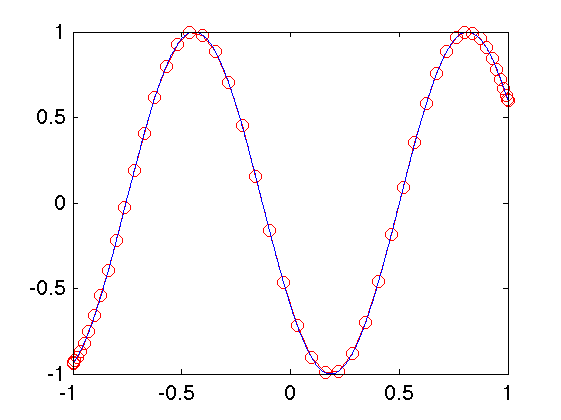

In [15]:
utrue_func = @(x,t) sin(5*(x+t-0.5));
g_func = @(t) utrue_func(1,t);

x_all = chebpts(N);     % note that this returns points ordered from -1 to 1
x = x_all(1:N-1);    % interior points, other than right boundary

u = utrue_func(x,0.);
u_all = [u; g_func(0)];   % append boundary value for plotting
plot(x_all,u_all,'r-o');

hold on
xfine = linspace(-1,1,1000);
ufine = utrue_func(xfine, 0.);
plot(xfine,ufine,'b')

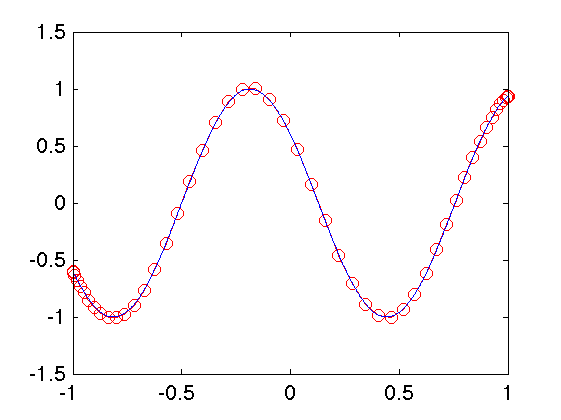

In [16]:
u = utrue_func(x,0.);

tfinal = 1.;
nmax = 0.5*N^2;
dt = tfinal/nmax;

for n=1:nmax
    t1 = (n-1)*dt;
    b = g_func(t1) * d;
    u = u + dt*(D*u + b);
    end

u_all = [u; g_func(tfinal)];   % append boundary value for plotting
plot(x_all,u_all,'r-o');

hold on
xfine = linspace(-1,1,1000);
ufine = utrue_func(xfine, tfinal);
plot(xfine,ufine,'b')

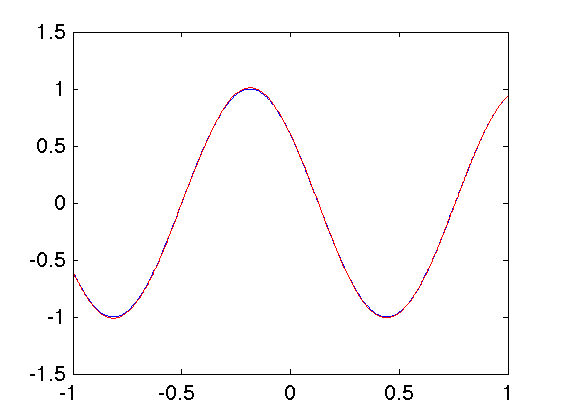

max_error =
   0.010062084437466

In [17]:
pn = chebfun(u_all);
phat = chebfun(@(x) utrue_func(x,tfinal));
max_error = norm(pn-phat,inf)
plot(phat,'b')
hold on 
plot(pn,'r')

The error is smaller than with the Gaussian because the function is smoother.